In [ ]:
!pip install mne torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving 1_P3.set to 1_P3.set


Saving 1_P3.fdt to 1_P3.fdt


In [ ]:
!pip install mne


Reading /content/1_P3.fdt
Reading 0 ... 478207  =      0.000 ...   466.999 secs...
Using matplotlib as 2D backend.


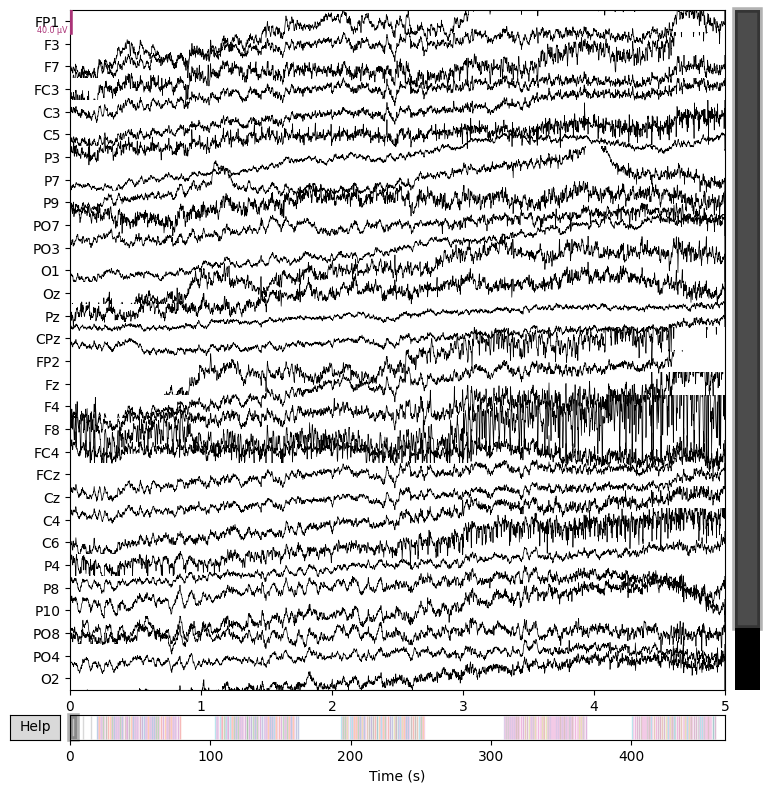

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-6-be4033bbeb6e>:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


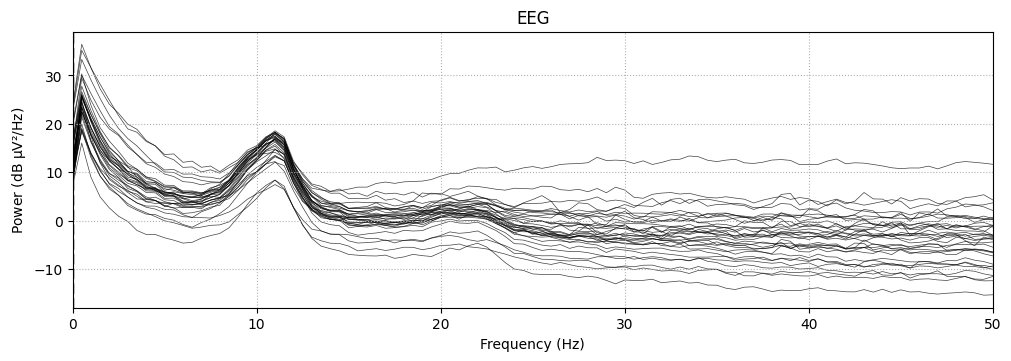

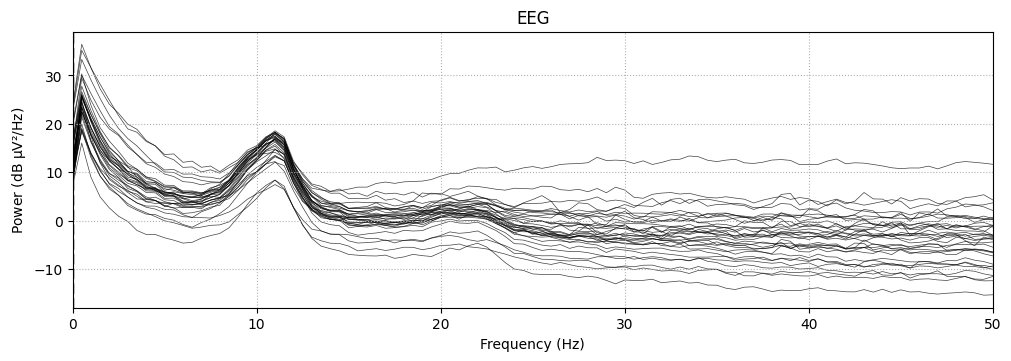

In [ ]:
import mne
import matplotlib.pyplot as plt

# File name for the .set file
file_path = '1_P3.set'

# Load the EEG dataset
raw = mne.io.read_raw_eeglab(file_path, preload=True)

# Plot the raw data with 10 channels and a duration of 5 seconds
raw.plot(n_channels=30, duration=5, show=True)

# Plot the power spectral density (PSD) for frequencies up to 50 Hz
raw.plot_psd(fmax=50)


In [ ]:
import mne
import pandas as pd

# File path for the .set file
file_path = '1_P3.set'

# Load the dataset
raw = mne.io.read_raw_eeglab(file_path, preload=True)

# Extract the data and time points
data, times = raw.get_data(return_times=True)

# Create a Pandas DataFrame with channels as columns and time points as index
df = pd.DataFrame(data.T, columns=raw.ch_names)
df['Time (s)'] = times  # Add the time points as a separate column

# Move the time column to the front
df = df[['Time (s)'] + raw.ch_names]

# Display the full dataset (this might be large for the notebook)
print(df)

# Optionally: Save the full dataset to a CSV file (if you want to download it)
df.to_csv('EEG_full_dataset.csv', index=False)


Reading /content/1_P3.fdt
Reading 0 ... 478207  =      0.000 ...   466.999 secs...
          Time (s)       FP1        F3        F7       FC3        C3  \
0         0.000000 -0.020517 -0.005120  0.010532 -0.002808 -0.002921   
1         0.000977 -0.020515 -0.005120  0.010537 -0.002807 -0.002922   
2         0.001953 -0.020515 -0.005121  0.010538 -0.002808 -0.002923   
3         0.002930 -0.020518 -0.005124  0.010535 -0.002811 -0.002926   
4         0.003906 -0.020522 -0.005127  0.010533 -0.002813 -0.002927   
...            ...       ...       ...       ...       ...       ...   
478203  466.995117 -0.015443 -0.002228  0.012085 -0.000191  0.001288   
478204  466.996094 -0.015442 -0.002224  0.012085 -0.000189  0.001288   
478205  466.997070 -0.015442 -0.002224  0.012085 -0.000189  0.001288   
478206  466.998047 -0.015442 -0.002225  0.012087 -0.000190  0.001288   
478207  466.999023 -0.015445 -0.002226  0.012087 -0.000192  0.001287   

              C5        P3        P7        P9  ... 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from google.colab import files

# Upload train_data.npy
uploaded = files.upload()
# Upload test_data.npy
uploaded = files.upload()
# Upload Y_train.npy
uploaded = files.upload()
# Upload true_labels.csv
uploaded = files.upload()

Saving X_test.npy to X_test.npy


Saving X_train.npy to X_train.npy


Saving Y_train.npy to Y_train.npy


Saving true_labels.csv to true_labels.csv


In [ ]:
# Load train and test data
train_data_list = np.load('X_train.npy')
test_data_list = np.load('X_test.npy')

# Calculate the correct reshape dimensions
num_channels = 30  # Number of EEG channels
# Assuming the total data points per trial is 210 and you have 56 channels
# num_time_points = train_data_list.shape[1] // num_channels
num_time_points = train_data_list.shape[1] // num_channels


# Reshape the data
X_train = train_data_list.reshape(train_data_list.shape[0], num_channels, num_time_points)
X_test = test_data_list.reshape(test_data_list.shape[0], num_channels, num_time_points)

Y_train = np.load('Y_train.npy')
Y_test = np.reshape(pd.read_csv('true_labels.csv', header=None).values, 3400)

# Normalize data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
!pip install torchinfo
import torchinfo

In [ ]:
# Define EEGNet model
class EEGNet(nn.Module):
    def __init__(self, num_classes, input_shape):  # Add input_shape as an argument
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), padding=(0, 25)),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            # Changed kernel size to (30, 1) to match input channels
            nn.Conv2d(16, 32, (30, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 2)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 2)),
            nn.Dropout(0.25)
        )
        # Pass input_shape to _get_conv_output
        self._num_features_for_linear = self._get_conv_output(input_shape)
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._num_features_for_linear, num_classes)
        )

    def _get_conv_output(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.firstconv(x)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            x = x.view(1, -1)
            return x.size(1)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classify(x)
        return x

#  Pass the expected input shape to the model
model = EEGNet(num_classes=2, input_shape=(1, 30, 7))
torchinfo.summary(model, input_size=(32, 1, 30, 7))

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [32, 2]                   --
├─Sequential: 1-1                        [32, 16, 30, 7]           --
│    └─Conv2d: 2-1                       [32, 16, 30, 7]           832
│    └─BatchNorm2d: 2-2                  [32, 16, 30, 7]           32
├─Sequential: 1-2                        [32, 32, 1, 3]            --
│    └─Conv2d: 2-3                       [32, 32, 1, 7]            960
│    └─BatchNorm2d: 2-4                  [32, 32, 1, 7]            64
│    └─ELU: 2-5                          [32, 32, 1, 7]            --
│    └─AvgPool2d: 2-6                    [32, 32, 1, 3]            --
│    └─Dropout: 2-7                      [32, 32, 1, 3]            --
├─Sequential: 1-3                        [32, 32, 1, 1]            --
│    └─Conv2d: 2-8                       [32, 32, 1, 3]            15,360
│    └─BatchNorm2d: 2-9                  [32, 32, 1, 3]            64
│    └─EL

Epoch 1/200, Loss: 0.2891
Epoch 2/200, Loss: 0.2894
Epoch 3/200, Loss: 0.3004
Epoch 4/200, Loss: 0.2938
Epoch 5/200, Loss: 0.2809
Epoch 6/200, Loss: 0.2904
Epoch 7/200, Loss: 0.2905
Epoch 8/200, Loss: 0.2854
Epoch 9/200, Loss: 0.2884
Epoch 10/200, Loss: 0.2953
Epoch 11/200, Loss: 0.2842
Epoch 12/200, Loss: 0.2922
Epoch 13/200, Loss: 0.2792
Epoch 14/200, Loss: 0.2998
Epoch 15/200, Loss: 0.2898
Epoch 16/200, Loss: 0.2910
Epoch 17/200, Loss: 0.2803
Epoch 18/200, Loss: 0.2852
Epoch 19/200, Loss: 0.2987
Epoch 20/200, Loss: 0.2866
Epoch 21/200, Loss: 0.2866
Epoch 22/200, Loss: 0.2960
Epoch 23/200, Loss: 0.2785
Epoch 24/200, Loss: 0.2768
Epoch 25/200, Loss: 0.2859
Epoch 26/200, Loss: 0.2996
Epoch 27/200, Loss: 0.2965
Epoch 28/200, Loss: 0.2881
Epoch 29/200, Loss: 0.2801
Epoch 30/200, Loss: 0.2861
Epoch 31/200, Loss: 0.2852
Epoch 32/200, Loss: 0.2896
Epoch 33/200, Loss: 0.2934
Epoch 34/200, Loss: 0.2741
Epoch 35/200, Loss: 0.2822
Epoch 36/200, Loss: 0.2817
Epoch 37/200, Loss: 0.2852
Epoch 38/2

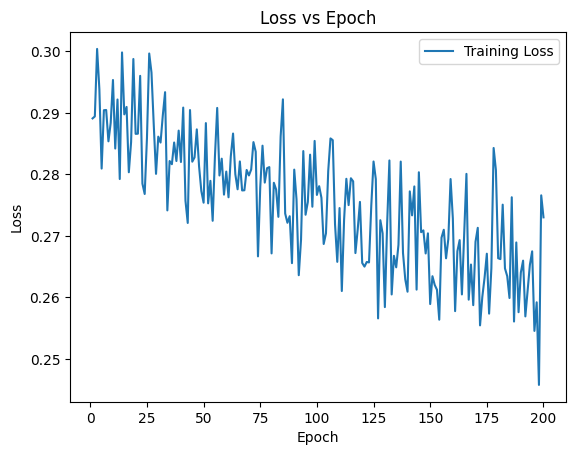

In [ ]:
# Create model instance

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
num_epochs = 200

# Lists to store losses and epochs
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)  # Add channel dimension for Conv2d input
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
model.eval()
total = 0
correct = 0
all_labels = []
all_probs = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.unsqueeze(1)  # Add channel dimension for Conv2d input
        outputs = model(data)
        probs = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_labels.extend(target.numpy())
        all_probs.extend(probs.numpy()[:, 1])  # Get probabilities for class 1

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 65.76470588235294%


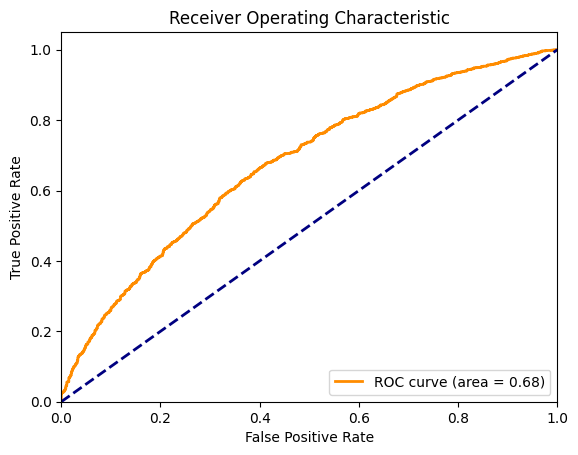

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
num_epochs = 1

# Lists to store losses and epochs
epoch_losses = []
import time
import torch
import torch.nn as nn

# Define the number of runs
num_runs = 20

model.eval()
total = 0
correct = 0
all_labels = []
all_probs = []
inference_times = []

for run in range(num_runs):
    # Measure inference time
    start_time = time.time()

    with torch.no_grad():
        for data, target in test_loader:
            data = data.unsqueeze(1)  # Add channel dimension for Conv2d input
            outputs = model(data)
            probs = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_labels.extend(target.numpy())
            all_probs.extend(probs.numpy()[:, 1])  # Get probabilities for class 1

    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)

# Calculate average inference time
average_inference_time = sum(inference_times) / num_runs

print(f'Accuracy: {100 * correct / total}%')
print(f'Average inference time over {num_runs} runs: {average_inference_time:.4f} seconds')


Accuracy: 65.76470588235294%
Average inference time over 20 runs: 0.5215 seconds
